In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
data_dir = "F:\\SAVERA\\from 2-SEP-2018\\savera-raw-data"
# data_dir = '/media/virk/SBPD/SAVERA/from 2-SEP-2018/savera-raw-data'
imgs_dir = os.path.join(data_dir, "Roofs")
masks_dir = os.path.join(data_dir, "Annotation")

### Get input images and their masks together

In [3]:
imgs_paths = []
for root, dirs, files in os.walk(imgs_dir):
    for imgname in files:
        img_fullpath = os.path.join(root, imgname)
        imgs_paths.append(img_fullpath)
mask_paths = []
for root, dirs, files in os.walk(masks_dir):
    for maskname in files:
        mask_fullpath = os.path.join(root, maskname)
        mask_paths.append(mask_fullpath)
imgs_paths.sort()
mask_paths.sort()
# Make pair of image and its masks
img_mask_paths_pair = {}
image_counter = 0
for imgpath in imgs_paths:
    img = cv2.imread(imgpath)
    if (img.shape[0] < 256) or (img.shape[1] < 256):
        print("Dimensions not appropriate.\nRequired: (256, 256)\nFound:", img.shape[:2])
        print()
    else:
        image_counter += 1
        if os.path.split(imgpath)[1].split(".")[0].split("_")[0] == "NPB":
            imgname = os.path.split(imgpath)[1].split(".")[0].split("_")[1]
            for maskpath in mask_paths:
                maskname = os.path.split(maskpath)[1].split(".")[0].split("_")[1]
                if maskname == imgname:
#                     print("Matched:\n", imgpath, "\n", maskpath)
                    if imgpath not in img_mask_paths_pair.keys():
                        img_mask_paths_pair[imgpath] = []
                        img_mask_paths_pair[imgpath].append(maskpath)
                    else:
                        img_mask_paths_pair[imgpath].append(maskpath)        
        else:
            imgname = os.path.split(imgpath)[1].split(".")[0]
            for maskpath in mask_paths:
                maskname = os.path.split(maskpath)[1].split(".")[0].split("_")[0]
                if maskname == imgname:
    #                 print("Matched:\n", imgpath, "\n", maskpath)
                    if imgpath not in img_mask_paths_pair.keys():
                        img_mask_paths_pair[imgpath] = []
                        img_mask_paths_pair[imgpath].append(maskpath)
                    else:
                        img_mask_paths_pair[imgpath].append(maskpath)
print("{} out of {} passed.".format(image_counter, len(imgs_paths)))

86 out of 86 passed.


In [4]:
def data_generator(paths_dict, batchsize=8, outshape=(256, 256)):
    """
    paths_dict: Python Dictionary contains image path as key and list of mask paths as value.
    batchsize: number of images and masks in a batch
    outshape: shape of the images and masks. Default is 256 for U-net model
    """
    counter = 0
    img_batch = []
    mask_batch = []
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    for imgpath in paths_dict.keys():
        counter += 1
        img = cv2.imread(imgpath)
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
#         img = cv2.filter2D(img, -1, kernel) # image sharpening
        img = cv2.resize(img, outshape) / 255 # Normalize image
        
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        for maskpath in paths_dict[imgpath]:
            mask = cv2.resize(mask, outshape)
            tmpmask = cv2.imread(maskpath, 0)
            tmpmask = cv2.resize(tmpmask, outshape)
            mask = cv2.bitwise_or(mask, tmpmask)
        mask = np.expand_dims(mask, -1) / 255 # Normalize image
            
        img_batch.append(img[np.newaxis, ...])
        mask_batch.append(mask[np.newaxis, ...])
        if counter % batchsize == 0:
            yield np.concatenate(img_batch, axis=0), np.concatenate(mask_batch, axis=0)
            counter = 0
            img_batch = []
            mask_batch = []

In [5]:
# PARAMETERS
BATCHSIZE = 8
MODEL_INPUT_SHAPE = (256, 256)

### Train-Val split

In [6]:
train_size = 80
train_paths = dict(list(img_mask_paths_pair.items())[:train_size])
val_paths = dict(list(img_mask_paths_pair.items())[train_size:])
                   
len(train_paths), len(val_paths)

(80, 6)

### Visualization

Batch size: (8, 256, 256, 3) (8, 256, 256, 1)


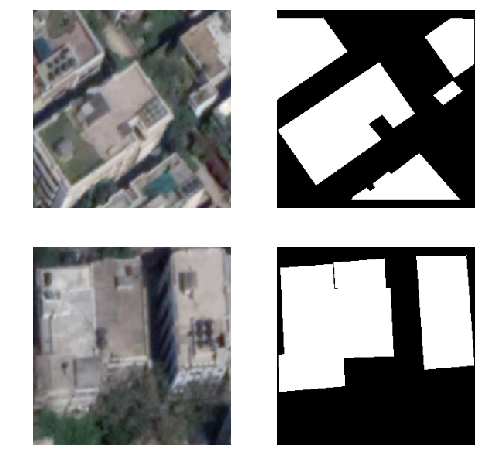

In [7]:
imgs, masks = next(data_generator(img_mask_paths_pair))
print("Batch size:", imgs.shape, masks.shape)
plt.figure(figsize=(8,8))
plt.tight_layout()
plt.subplot(2,2,1)
plt.axis('off')
plt.imshow(imgs[4])
plt.subplot(2,2,2)
plt.axis('off')
plt.imshow(masks[4].reshape(masks[4].shape[:2]), cmap='gray')
plt.subplot(2,2,3)
plt.axis('off')
plt.imshow(imgs[2])
plt.subplot(2,2,4)
plt.axis('off')
plt.imshow(masks[2].reshape(masks[2].shape[:2]), cmap='gray')
plt.show()

### Data Augmentation

In [8]:
# Training mask and images generator
traingen = data_generator(train_paths, len(train_paths), MODEL_INPUT_SHAPE)
trainX, trainY = next(traingen)
print("trainX shape: {} trainY shape: {}".format(trainX.shape, trainY.shape))
# Validation mask and images generator
valgen = data_generator(val_paths, len(val_paths), MODEL_INPUT_SHAPE)
valX, valY = next(valgen)
print("valX shape: {} valY shape: {}".format(valX.shape, valY.shape))
# Keras Training Generator for Augmentation
from tensorflow.keras.preprocessing import image as Kimage
trainKgen = Kimage.ImageDataGenerator(rotation_range=12, 
                               width_shift_range=0.10, 
                               shear_range=0.5,
                               height_shift_range=0.10, 
                               zoom_range=0.10
                              )

trainX shape: (80, 256, 256, 3) trainY shape: (80, 256, 256, 1)
valX shape: (6, 256, 256, 3) valY shape: (6, 256, 256, 1)


## Model

In [9]:
from u_net import get_unet_256
from custom_losses_and_metrics import bce_dice_loss, dice_coeff
from tensorflow.keras.optimizers import RMSprop
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

## intersection over union
def IoU(y_true, y_pred, eps=1e-6):
    if np.max(y_true) == 0.0:
        return IoU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean( (intersection + eps) / (union + eps), axis=0)

model = get_unet_256()
model.compile(optimizer=RMSprop(lr=0.0001), loss=bce_dice_loss, metrics=[dice_coeff])
# model.compile(optimizer=Adam(1e-3, decay=1e-6), loss=IoU, metrics=['binary_accuracy'])

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
weight_path="SAVERA_86_trained_weights(.7217)/{}_weights.best.hdf5".format('SAVERA_86_trained')
checkpoint = ModelCheckpoint(weight_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             save_weights_only=True
                            )
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', 
                                   factor=0.2,
                                   patience=1, 
                                   verbose=1, 
                                   mode='min',
                                   min_delta=0.0001, 
                                   cooldown=0, 
                                   min_lr=1e-8
                                  )
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      verbose=2,
                      patience=20 # probably needs to be more patient
                     )

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [11]:
# LOAD CHECKPOINT (IF ANY)
try:
    model.load_weights(weight_path)
    print("CheckPoint loaded!")
except:
    print("No CheckPoint found.")
    pass
    
# START TRAINING
history = model.fit_generator(
    generator=trainKgen.flow(trainX, trainY, batch_size=BATCHSIZE),
#     generator=traingen,
    steps_per_epoch=len(train_paths)/2,#//BATCHSIZE,
    validation_data=(valX, valY),
    validation_steps=1,
    epochs=200,
    callbacks=callbacks_list
)

No CheckPoint found.
Epoch 1/500
39/40 [============================>.] - ETA: 0s - loss: 1.0019 - dice_coeff: 0.5841
Epoch 00001: val_loss improved from inf to 1.20113, saving model to chkpt/SAVERA_86_trained_weights.best.hdf5
40/40 [==============================] - 28s 690ms/step - loss: 1.0015 - dice_coeff: 0.5846 - val_loss: 1.2011 - val_dice_coeff: 0.4945
Epoch 2/500
39/40 [============================>.] - ETA: 0s - loss: 0.8833 - dice_coeff: 0.6359
Epoch 00002: val_loss did not improve from 1.20113

Epoch 00002: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
40/40 [==============================] - 11s 284ms/step - loss: 0.8810 - dice_coeff: 0.6375 - val_loss: 1.2471 - val_dice_coeff: 0.5511
Epoch 3/500
39/40 [============================>.] - ETA: 0s - loss: 0.7546 - dice_coeff: 0.6863
Epoch 00003: val_loss did not improve from 1.20113

Epoch 00003: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
40/40 [==============================] - 

Epoch 26/500
39/40 [============================>.] - ETA: 0s - loss: 0.6853 - dice_coeff: 0.7121
Epoch 00026: val_loss did not improve from 0.67100
40/40 [==============================] - 12s 291ms/step - loss: 0.6848 - dice_coeff: 0.7123 - val_loss: 0.6728 - val_dice_coeff: 0.7213
Epoch 27/500
39/40 [============================>.] - ETA: 0s - loss: 0.6915 - dice_coeff: 0.7099
Epoch 00027: val_loss did not improve from 0.67100
40/40 [==============================] - 12s 291ms/step - loss: 0.6918 - dice_coeff: 0.7095 - val_loss: 0.6727 - val_dice_coeff: 0.7215
Epoch 28/500
39/40 [============================>.] - ETA: 0s - loss: 0.6949 - dice_coeff: 0.7083
Epoch 00028: val_loss did not improve from 0.67100
40/40 [==============================] - 12s 291ms/step - loss: 0.6943 - dice_coeff: 0.7092 - val_loss: 0.6723 - val_dice_coeff: 0.7218
Epoch 29/500
39/40 [============================>.] - ETA: 0s - loss: 0.6949 - dice_coeff: 0.7090
Epoch 00029: val_loss did not improve from 0.67

In [12]:
# # SAVE MODEL
# # model.save('SAVERA_86_trained.h5')
# model.save_weights('SAVERA_86_trained_weights.h5')

In [13]:
# # from keras.models import load_model
# # # LOAD MODEL
# # model = load_model('SAVERA_86_trained.h5', custom_objects={
# #     'bce_dice_loss':bce_dice_loss,
# #     'dice_coeff':dice_coeff
# # })
# model.load_weights('SAVERA_86_trained_weights.h5')

### Traning quality

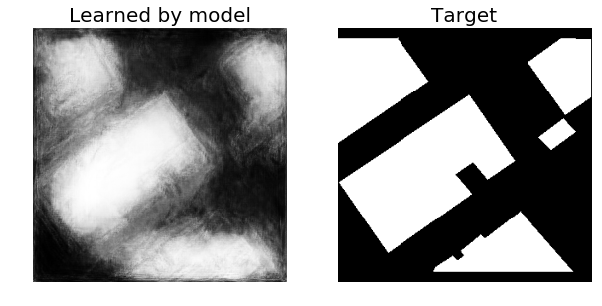

In [14]:
img_no = 4
testimg = trainX[img_no].reshape(1, 256, 256, 3)
targetmask = trainY[img_no].reshape(MODEL_INPUT_SHAPE)
pred = model.predict(testimg)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Learned by model', fontsize=20)
plt.imshow(pred.reshape(MODEL_INPUT_SHAPE), cmap='gray')
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Target', fontsize=20)
plt.imshow(targetmask, cmap='gray')
plt.show()

### Validation

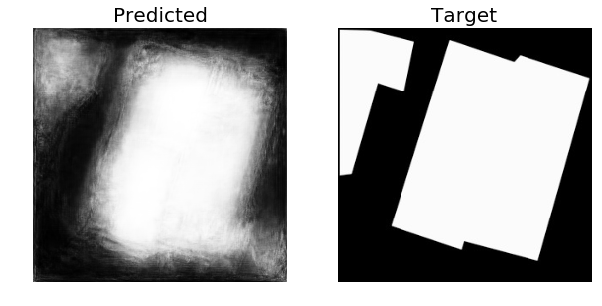

In [15]:
img_no = 3
testimg = valX[img_no].reshape(1, 256, 256, 3)
targetmask = valY[img_no].reshape(MODEL_INPUT_SHAPE)
pred = model.predict(testimg)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Predicted', fontsize=20)
plt.imshow(pred.reshape(MODEL_INPUT_SHAPE), cmap='gray')
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Target', fontsize=20)
plt.imshow(targetmask, cmap='gray')
plt.show()